In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import cv2
from sklearn import metrics

In [2]:
folder_train = "/kaggle/input/histopathologic-cancer-detection/train/"
folder_test = "/kaggle/input/histopathologic-cancer-detection/test/"

In [3]:
sample_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
label_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")


In [4]:
train_name = label_df["id"].to_numpy()
test_name =  sample_df["id"].to_numpy()
train_label = label_df["label"].to_numpy()

## Samples

In [5]:
def plot_photo(N, nc = 4, pos = True):
    
    nr =  math.ceil(N/nc)
    n_train = train_name.shape[0]
    fig, ax = plt.subplots(nr, nc, figsize = (15, nr*3.2))
    
    np.random.seed(1)
    
    IDs = np.random.choice(n_train, N, replace = False)
    
    if pos:
        filter1 = train_label == 1
    else:
        filter1 = train_label == 0
        
    names_1 = train_name[filter1]
    
    names = np.random.choice(names_1, N, replace = False)
    
    for k in range(N):
        i =  int(k/nc)
        j = k % nc
        fname =  folder_train + names[k] + ".tif"
        img = cv2.imread(fname)
        ax[i,j].imshow(img)
        


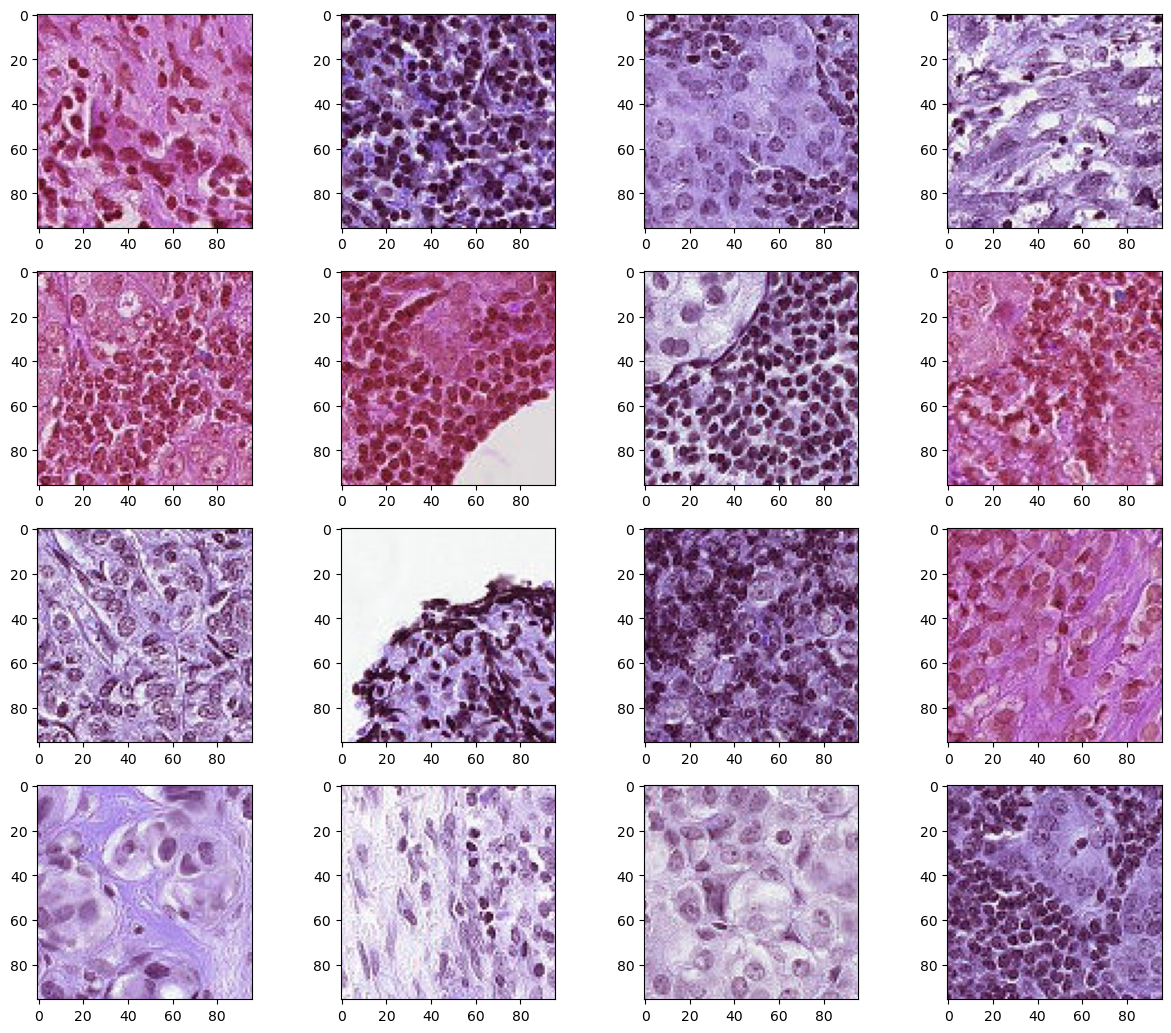

In [6]:
plot_photo(16)

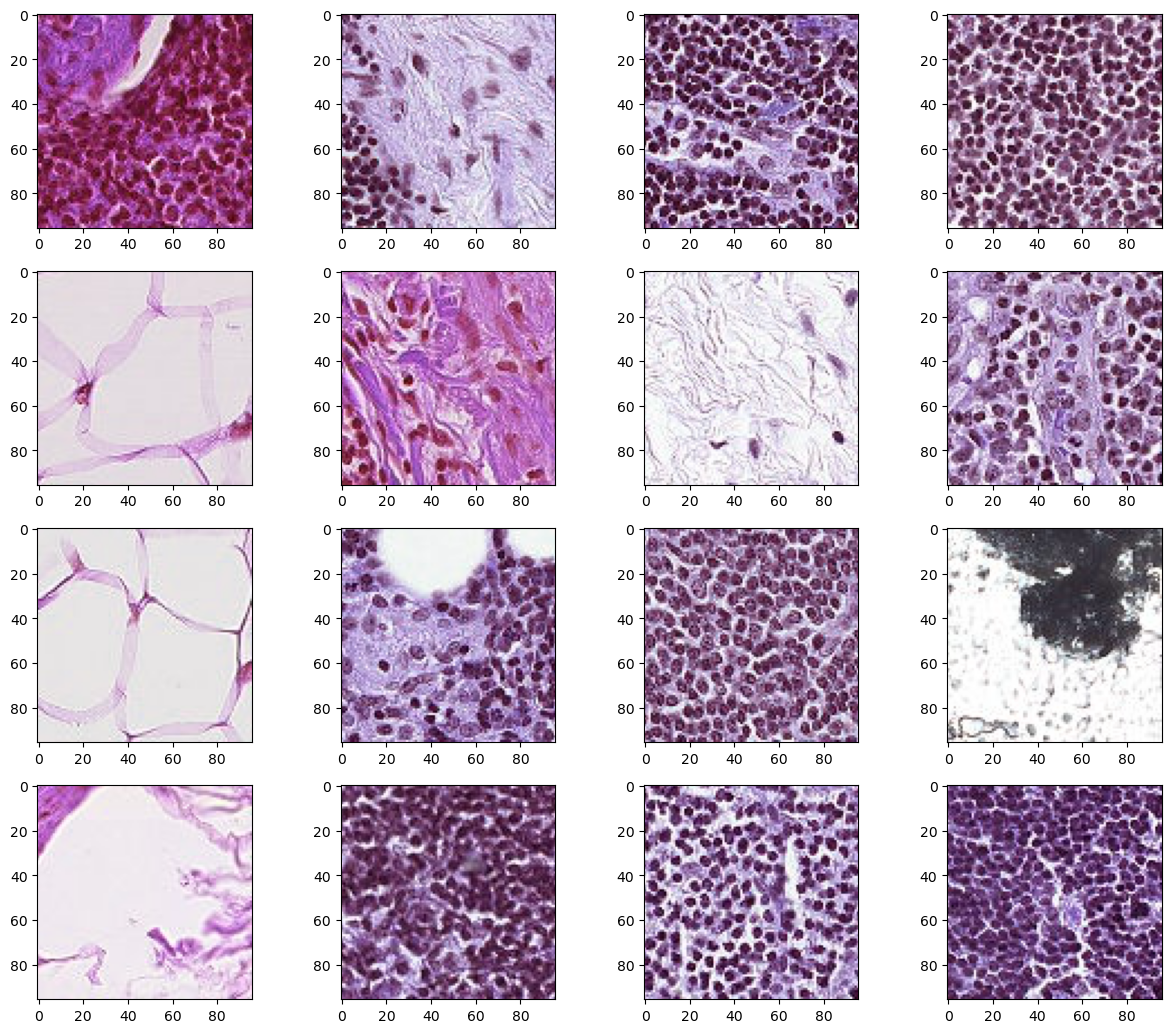

In [7]:
plot_photo(16, pos = False)

## Balanced sampling and create X and y
### functions

In [8]:
def balanced_sampling(n_sample):

    indx_pos = np.where(train_label == 1)[0]
    indx_neg = np.where(train_label == 0)[0]
    
    np.random.seed(1)
    sample_pos = np.random.choice(indx_pos, n_sample, replace = False)
    sample_neg = np.random.choice(indx_neg, n_sample, replace = False)
    
    sample_idx = np.concatenate((sample_pos, sample_neg))
    
    np.random.shuffle(sample_idx)
    
    return sample_idx
    

In [9]:
def create_traindata(idxs, margin):
    
    time1 = time.time()
    
    n = idxs.shape[0]
    
    X_array = np.zeros((n, 32 + 2*margin, 32 + 2*margin, 3)).astype("uint8")
    
    names = train_name[idxs]
    
    y_array = train_label[idxs]
    
    start = 32 - margin
    end = 64 + margin
    
    for i in range(n):
        
        fname =  folder_train + names[i] + ".tif"
        img = cv2.imread(fname)
        
        X_array[i,:,:,:] = img[start:end,start:end,:]
        
        
    time2 = time.time()
    
    time3 = np.round(time2 - time1)
    print(time3, "sec")
                     
    return X_array, y_array.reshape(-1, 1)

In [10]:
def create_testdata(margin):
    
    time1 = time.time()
    
    names = test_name
    
    n = names.shape[0]
    print("n_test = ", n)
    X_array = np.zeros((n, 32 + 2*margin, 32 + 2*margin, 3)).astype("uint8")

    start = 32 - margin
    end = 64 + margin
    
    for i in range(n):
        
        fname =  folder_test + names[i] + ".tif"
        img = cv2.imread(fname)
        
        X_array[i,:,:,:] = img[start:end,start:end,:]
        
        
    time2 = time.time()
    
    time3 = np.round(time2 - time1)
    print(time3, "sec")
                     
    return X_array

### create data

In [11]:
n_sample = int(170000/2) 
sample_indx = balanced_sampling(n_sample)
n_val = 10000
val_idxs = sample_indx[:n_val]
train_idxs = sample_indx[n_val:]
print(val_idxs.shape, train_idxs.shape)

(10000,) (160000,)


In [12]:
train_label[sample_indx].mean()

0.5

In [13]:
margin = 32

In [14]:
X_val, y_val = create_traindata(val_idxs[0:10], margin)
X_val.shape

0.0 sec


(10, 96, 96, 3)

In [15]:
X_val, y_val = create_traindata(val_idxs, margin)
X_val.shape

84.0 sec


(10000, 96, 96, 3)

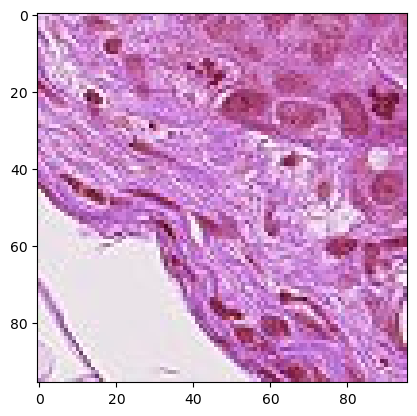

In [16]:
plt.imshow(X_val[2])

In [17]:
X_train, y_train = create_traindata(train_idxs, margin)

1374.0 sec


In [18]:
X_train.shape, X_val.shape

((160000, 96, 96, 3), (10000, 96, 96, 3))

In [19]:
X_test = create_testdata(margin)

n_test =  57458
454.0 sec


In [20]:
X_test.shape

(57458, 96, 96, 3)

### save files

In [21]:
#validation data  (balanced)
np.save("X_val", X_val)
np.save("y_val", y_val)

In [22]:
#50000 samples of train data (balanced)
np.save("X_train_s", X_train[0:50000])
np.save("y_train_s", y_train[0:50000])

In [23]:
#full train data (balanced)
np.save("X_train", X_train)
np.save("y_train", y_train)

In [24]:
#test data
np.save("X_test", X_test)
